In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm_notebook as tqdm

from matplotlib import rc
from copy import deepcopy
import matplotlib

/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [3]:
import matplotlib

font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

## Реализуем крестики-нолики

In [4]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [5]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()
        
        self.action_space = self.getEmptySpaces()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces
    
    def getActiveActions(self):
        res = np.where(self.board == 0)
        return np.array([ (self.n_rows * i + j) for i,j in zip(res[0], res[1]) ])

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash
    
    def getStateTensor(self):
        l0 = torch.tensor((self.board == 0).astype(np.float32))
        l1 = torch.tensor((self.board == 1).astype(np.float32))
        l2 = torch.tensor((self.board == -1).astype(np.float32))
        return torch.stack([l0, l1, l2]).unsqueeze(0)

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):        
        if self.board[action[0], action[1]] != 0:
            self.curTurn = -self.curTurn
            return self.getState(), -10, True, {}, self.getStateTensor()
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}, self.getStateTensor()

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [6]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    fig.canvas.draw()
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getAction(s, actions)

In [7]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info, _ = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

### Q-LEARNING

In [8]:
def test_game(env, pi1, pi2):
    done = False
    reward = 0
    env.reset()
    history1 = []
    history2 = []
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = pi1.getAction(s, actions)
            history1.append((s, a))
        else:
            a = pi2.getAction(s, actions)
            history2.append((s, a))
        _, reward, done, _, _ = env.step(actions[a])
    return reward, history1, history2

def score_strategy(env, pi, pi_against, iters=1e5):
    assert pi.crosses != pi_against.crosses
    
    pi.eval = True
    pi_against.eval = True
    
    if pi.crosses:
        return np.array([test_game(env, pi, pi_against)[0] for _ in range(int(iters))]).mean()
    else:
        return -np.array([test_game(env, pi_against, pi)[0] for _ in range(int(iters))]).mean()

In [9]:
class Pi:
    def __init__(self, crosses=True, random_strategy=False, epsilon=0.1):
        self.Q = dict()
        self.crosses = crosses
        self.random_strategy = random_strategy
        self.epsilon = 0.1
        self.eval = False
        
    def getAction(self, s, actions):        
        if not self.random_strategy and s not in self.Q:            
            self.Q[s] = 1 - 2 * np.random.rand(len(actions))
        if self.random_strategy or not self.eval and self.epsilon and np.random.random() < self.epsilon:
            return np.random.randint(len(actions))        
        return np.argmax(self.Q[s])

class QLearning:
    def __init__(self, env, lr=0.1, epsilon=0.1):
        self.pi_crosses = Pi(crosses=True, random_strategy=False, epsilon=epsilon)
        self.pi_naughts = Pi(crosses=False, random_strategy=False, epsilon=epsilon)
        self.env = env
        self.lr = lr
        
        self.mean_rewards = []
        self.crosses_rnd_scores = []
        self.naughts_rnd_scores = []        
    
    def fit(self, iters=1e5):
        self.pi_crosses.eval = False
        self.pi_naughts.eval = False
       
        rewards = []  
        
        for i in tqdm(range(int(iters) + 1)):                
            reward, hist1, hist2 = test_game(self.env, self.pi_crosses, self.pi_naughts)
            
            rewards.append(reward)

            if not self.pi_crosses.random_strategy:
                self.update_strategy(self.pi_crosses, reward, hist1, self.lr)
            
            if not self.pi_naughts.random_strategy:
                self.update_strategy(self.pi_naughts, -reward, hist2, self.lr)
                
            if i % 10000 == 0:  
                self.score_progress(i, rewards)
                
    def score_progress(self, i, rewards):
        self.crosses_rnd_scores.append(score_strategy(self.env, self.pi_crosses, 
                                                         Pi(crosses=False, random_strategy=True), iters=2000))                
        self.naughts_rnd_scores.append(score_strategy(self.env, self.pi_naughts,
                                                 Pi(crosses=True, random_strategy=True), iters=2000))

        self.pi_crosses.eval = False
        self.pi_naughts.eval = False
        self.mean_rewards.append(0 if not rewards else sum(rewards) / len(rewards))
        rewards = []
        print(f'iter {i}: scores crosses {self.crosses_rnd_scores[-1]}, naughts: {self.naughts_rnd_scores[-1]}, cur mean rewards: {self.mean_rewards[-1]}')

    @staticmethod
    def update_strategy(pi, reward, history, lr):
        pi.Q[history[-1][0]][history[-1][1]] = (1 - lr) * pi.Q[history[-1][0]][history[-1][1]] + lr * reward
        
        for i in range(len(history) - 1):
            next_state, next_action = history[-i - 1]
            cur_state, cur_action = history[-i - 2]
            pi.Q[cur_state][cur_action] = ((1 - lr) * pi.Q[cur_state][cur_action] + 
                                           lr * (reward + np.max(pi.Q[next_state])))
            
            
    def plot_progress(self):
        plt.figure(figsize=(14, 6))
        plt.plot(self.mean_rewards, label='mean_rewards')  
        plt.plot(self.crosses_rnd_scores, label='crosses score againts random')
        plt.plot(self.naughts_rnd_scores, label='naughts score againts random')
        plt.legend()
        plt.show()

In [10]:
env3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
q3 = QLearning(env3)

env4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
q4 = QLearning(env4)

In [11]:
q3.fit(iters=400000)

/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


iter 0: scores crosses 0.5675, naughts: -0.2385, cur mean rewards: 1.0
iter 10000: scores crosses 0.952, naughts: 0.3375, cur mean rewards: 0.23567643235676433
iter 20000: scores crosses 0.9765, naughts: 0.4615, cur mean rewards: 0.2943852807359632
iter 30000: scores crosses 0.977, naughts: 0.439, cur mean rewards: 0.44101863271224295
iter 40000: scores crosses 0.946, naughts: 0.4175, cur mean rewards: 0.518312042198945
iter 50000: scores crosses 0.966, naughts: 0.3215, cur mean rewards: 0.5661286774264515
iter 60000: scores crosses 0.9715, naughts: 0.511, cur mean rewards: 0.5910734821086315
iter 70000: scores crosses 0.98, naughts: 0.5405, cur mean rewards: 0.5733489521578263
iter 80000: scores crosses 0.9535, naughts: 0.572, cur mean rewards: 0.5563055461806727
iter 90000: scores crosses 0.9825, naughts: 0.7095, cur mean rewards: 0.5458272685859046
iter 100000: scores crosses 0.978, naughts: 0.727, cur mean rewards: 0.5056049439505605
iter 110000: scores crosses 0.965, naughts: 0.70

В целом видно, что табличное обучение хорошо себя показало в обучении игры на доске 3x3. Крестики быстро выучили оптимальную стратегию, а нолики постепенно доучивались, причем ясно что чем лучше играли нолики, тем и крестики также доучивали новые ходы.

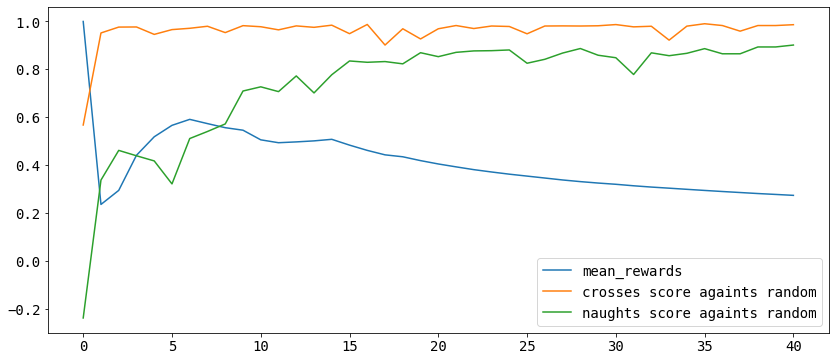

In [12]:
q3.plot_progress()

In [13]:
q4.fit(iters=400000)

/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


iter 0: scores crosses 0.0855, naughts: -0.058, cur mean rewards: 1.0
iter 10000: scores crosses 0.09, naughts: -0.0305, cur mean rewards: 0.0680931906809319
iter 20000: scores crosses 0.1345, naughts: -0.0535, cur mean rewards: 0.05344732763361832
iter 30000: scores crosses 0.1215, naughts: 0.011, cur mean rewards: 0.05023165894470184
iter 40000: scores crosses 0.147, naughts: -0.0055, cur mean rewards: 0.04599885002874928
iter 50000: scores crosses 0.0195, naughts: 0.0015, cur mean rewards: 0.04467910641787164
iter 60000: scores crosses 0.156, naughts: 0.04, cur mean rewards: 0.04843252612456459
iter 70000: scores crosses 0.1245, naughts: 0.0445, cur mean rewards: 0.04529935286638762
iter 80000: scores crosses 0.1545, naughts: 0.04, cur mean rewards: 0.04551193110086124
iter 90000: scores crosses 0.1795, naughts: 0.0075, cur mean rewards: 0.045543938400684436
iter 100000: scores crosses 0.1635, naughts: 0.0355, cur mean rewards: 0.046559534404655954
iter 110000: scores crosses 0.0425

На доске 4x4 все гораздо печальней - в целом видно, что обучение очень медленно, но потихоньку идет, возможно если провести очень много итераций данная стратегия доучится до приемлемых результатов. Но в целом текущий результат - неудовлетворительный, играют чуть лучше случайной стратегии.

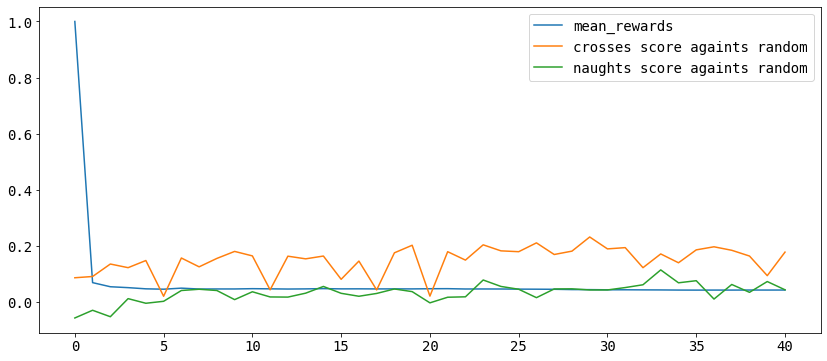

In [14]:
q4.plot_progress()

### DQN

In [190]:
def test_game_crosses(env, model, reset=True, score_with_rollouts=False):
    done = False
    reward = 0
    if reset:
        env.reset()
    pi = Pi(crosses=False, random_strategy=True)
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            if not score_with_rollouts:
                a = model(env.getStateTensor()).data.max(1)[1].view(1, 1)
            else:
                a = rollouts_step(env, model, True)
            _, reward, done, _, _ = env.step(env.action_space[a])
        else:
            a = pi.getAction(s, actions)
            _, reward, done, _, _ = env.step(actions[a])
    return (-10 if reward == -10 else reward)

def test_game_naughts(env, model, reset=True, score_with_rollouts=False):
    done = False
    reward = 0
    if reset:
        env.reset()
    pi = Pi(crosses=True, random_strategy=True)
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = pi.getAction(s, actions)
            _, reward, done, _, _ = env.step(actions[a])                        
        else:
            if not score_with_rollouts:
                a = model(env.getStateTensor()).data.max(1)[1].view(1, 1)
            else:
                a = rollouts_step(env, model, False)          
            _, reward, done, _, _ = env.step(env.action_space[a])
    return (-10 if reward == -10 else -reward)


def rollouts_step(env, model, crosses=True, iters=100):
    actions = env.getActiveActions()
    if len(actions) == 1:
        return actions[0]
    
    test_game = test_game_crosses if crosses else test_game_naughts
    
    r = dict()
    for a in actions:
        r[a] = [0]
        for i in range(int(iters / len(actions))):
            env_temp = deepcopy(env)
            _, reward, done, _, next_state_tensor = env_temp.step(env_temp.action_space[a])
            if not done:
                reward = test_game(env_temp, model, reset=False)
            elif reward == -10:
                continue
            elif not crosses:
                reward = -reward
            r[a].append(reward)
                
    a = np.array([sum(r[a]) / len(r[a]) for a in actions])
    return np.random.choice(a=actions[list(np.argwhere(a == max(a)).flatten())])

def score_strategy_nn(env, model, iters=2000, crosses=True, score_with_rollouts=False):
    if crosses:
        arr = np.array([test_game_crosses(env, model, score_with_rollouts=score_with_rollouts) for _ in range(int(iters))])
    else:
        arr = np.array([test_game_naughts(env, model, score_with_rollouts=score_with_rollouts) for _ in range(int(iters))])
    arr[arr == -10] = -1
    return arr.mean()

Первоначально я сделал вариант сетки со свертками. Но у меня постоянно были проблемы с обучением, нолики к примеру вообще не хотели обучаться, да и крестики с трудом. Когда я упростил архитектуру сети, модель стала обучаться заметно резвее. В целом ясно, что в данных задачах очень важен подбор правильных гиперпараметров обучения.

In [16]:
class TicTacToeNetwork(nn.Module):
    def __init__(self, n_cols, n_rows, layers=126):
        nn.Module.__init__(self)
        self.n_cols = n_cols
        self.n_rows = n_rows
        
        # Пробовал свертки, но они только все портилии в моем случае, особенно для ноликов
#         self.conv1 = nn.Conv2d(3, 1, (3, 3), padding=1)
#         self.conv2 = nn.Conv2d(3, 1, (3, 3), padding=1)
        self.dense1 = nn.Linear(3 * self.n_cols * self.n_rows, layers)
        self.dense2 = nn.Linear(layers, layers)
        self.dense3 = nn.Linear(layers, self.n_cols * self.n_rows)

    def forward(self, x):
#         y = self.conv1(x)
#         y = F.relu(y)
#         y = self.conv2(y)
#         y = F.relu(y)
        y = self.dense1(x.view(-1, 3 * self.n_cols * self.n_rows))
        y = F.relu(y)
        y = self.dense2(y)
        y = F.relu(y)
        y = self.dense3(y)
        return y

Я одновременно обучаю и крестики и нолики, и модели играют против друг друга. Параметрами можно включить double dqn или добавить режим rollouts

In [59]:
class TicTacToeDQN():
    def __init__(self, env, double_dqn=False, rollouts=False):
        self.env = env
        self.model_crosses = TicTacToeNetwork(env.n_cols, env.n_rows)
        self.model_naughts = TicTacToeNetwork(env.n_cols, env.n_rows)
        self.memory_crosses = ReplayMemory(10000)
        self.memory_naughts = ReplayMemory(10000)
        self.optimizer_crosses = optim.Adam(self.model_crosses.parameters(), 0.001)
        self.optimizer_naughts = optim.Adam(self.model_naughts.parameters(), 0.001)
        self.batch_size = 256
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 5000
        self.num_step = 0
        self.eps_threshold = 0
        
        self.rollouts = rollouts
        
        self.mean_rewards = []
        self.mean_crosses_draw = []
        self.mean_naughts_draw = []
        self.crosses_rnd_scores = []
        self.naughts_rnd_scores = []   
        
        self.crosses_draw = 0
        self.naughts_draw = 0
        self.rewards = []
        
        self.double_dqn = double_dqn
        
        self.target_net_crosses = TicTacToeNetwork(env.n_cols, env.n_rows)
        self.target_net_crosses.load_state_dict(self.model_crosses.state_dict())
        self.target_net_crosses.eval()
        
        self.target_net_naughts = TicTacToeNetwork(env.n_cols, env.n_rows)
        self.target_net_naughts.load_state_dict(self.model_naughts.state_dict())
        self.target_net_naughts.eval()
        
        self.target_update = 500
        

    def select_greedy_action(self, state, rollouts=False):
        if rollouts and self.env.curTurn == 1:
            a_r = rollouts_step(self.env, self.model_crosses, crosses=True)        
            return torch.tensor([[a_r]], dtype=torch.int32)
        if rollouts and self.env.curTurn == -1:
            a_r = rollouts_step(self.env, self.model_naughts, crosses=False)        
            return torch.tensor([[a_r]], dtype=torch.int32)
        if self.env.curTurn == 1:
            return self.model_crosses(state).data.max(1)[1].view(1, 1)
        else:
            return self.model_naughts(state).data.max(1)[1].view(1, 1)

    def select_action(self, state):
        sample = random.random()
        self.eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay) 
        if sample > self.eps_threshold:
            sample = random.random()
            if self.rollouts and sample > 1 - self.eps_threshold:
                return self.select_greedy_action(state, rollouts=True)
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(self.env.n_cols * self.env.n_rows)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, debug=False):
        self.env.reset()
        self.num_step = e
        history_crosses = []
        history_naughts = []
        
        while True:
            state_tensor = self.env.getStateTensor()
                        
            with torch.no_grad():
                action = self.select_action(state_tensor)    
                    
            _, reward, done, _, next_state_tensor = self.env.step(self.env.action_space[action.numpy()[0][0]])

            if self.env.curTurn == 1:
                history_naughts.append([state_tensor, action])
            else:
                history_crosses.append([state_tensor, action])
            
            state_tensor = next_state_tensor
            
            if done:
                if debug:
                    print(f"\tepisode {e} finished, reward {reward}, {self.env.curTurn}")
                break
                
        if reward == -10:
            if self.env.curTurn == -1:
                self.crosses_draw += 1
            else:
                self.naughts_draw += 1
        else:
            self.rewards.append(reward)
                
        t_c = []
        t_n = []

        for i in range(len(history_crosses) - 1):
            t_c.append(history_crosses[i] + [history_crosses[i + 1][0], torch.tensor([reward], dtype=torch.float32), False])
        t_c.append(history_crosses[-1] + [history_crosses[-1][0], torch.tensor([reward], dtype=torch.float32), True])

        for i in range(len(history_naughts) - 1):
            t_n.append(history_naughts[i] + [history_naughts[i + 1][0], torch.tensor([-reward], dtype=torch.float32), False])
        t_n.append(history_naughts[-1] + [history_naughts[-1][0], torch.tensor([-reward], dtype=torch.float32), True])
        
        if reward == -10:
            if self.env.curTurn == 1:
                for m in t_c:
                    m[-2] = torch.tensor([0], dtype=torch.float32)
                for m in t_n[:-1]:
                    m[-2] = torch.tensor([0], dtype=torch.float32)
                t_n[-1][-2] = torch.tensor([-10], dtype=torch.float32)
            else:
                for m in t_c[:-1]:
                    m[-2] = torch.tensor([0], dtype=torch.float32)
                for m in t_n:
                    m[-2] = torch.tensor([0], dtype=torch.float32)
                t_c[-1][-2] = torch.tensor([-10], dtype=torch.float32)
        
        for m in t_c:
            self.memory_crosses.store(m)
        for m in t_n:
            self.memory_naughts.store(m)
                
        if do_learning:
            target_net_crosses = self.model_crosses if not self.double_dqn else self.target_net_crosses
            target_net_naughts = self.model_naughts if not self.double_dqn else self.target_net_naughts
            
            self.learn(self.memory_crosses, self.model_crosses, self.optimizer_crosses, target_net_crosses)
            self.learn(self.memory_naughts, self.model_naughts, self.optimizer_naughts, target_net_naughts)
            
        if e % 1000 == 0:
            self.score_progress(e)
            
        if self.double_dqn and e % self.target_update == 0:
            self.target_net_crosses.load_state_dict(self.model_crosses.state_dict())
            self.target_net_naughts.load_state_dict(self.model_naughts.state_dict())
            
            
    def score_progress(self, i):
        if self.rollouts:
            self.crosses_rnd_scores.append(
                score_strategy_nn(env, self.model_crosses, crosses=True, score_with_rollouts=True, iters=100))
            self.naughts_rnd_scores.append(
                score_strategy_nn(env, self.model_naughts, crosses=False, score_with_rollouts=True, iters=100))
        else: 
            self.crosses_rnd_scores.append(score_strategy_nn(self.env, self.model_crosses))                
            self.naughts_rnd_scores.append(score_strategy_nn(self.env, self.model_naughts, crosses=False))
        self.mean_rewards.append(0 if not self.rewards else sum(self.rewards) / len(self.rewards))
        self.rewards = []
        self.mean_crosses_draw.append(self.crosses_draw / 1000)
        self.mean_naughts_draw.append(self.naughts_draw / 1000)
        self.crosses_draw = 0
        self.naughts_draw = 0
        print(f'iter {i}: scores crosses {self.crosses_rnd_scores[-1]}, naughts: {self.naughts_rnd_scores[-1]}, ' + 
              f'cur mean rewards: {self.mean_rewards[-1]}, crosses draws: {self.mean_crosses_draw[-1]}, naughts draws: {self.mean_naughts_draw[-1]}')
        
    def plot_progress(self):
        plt.figure(figsize=(14, 6))
        plt.plot(self.mean_rewards, label='mean_rewards')  
        plt.plot(self.crosses_rnd_scores, label='crosses score againts random')
        plt.plot(self.naughts_rnd_scores, label='naughts score againts random')
        plt.plot(self.mean_crosses_draw, label='mean crosses draws')
        plt.plot(self.mean_naughts_draw, label='mean naughts draws')
        plt.legend()
        plt.grid(True)
        plt.show()

    def learn(self, memory, model, optimizer, target_net):
        if len(memory) < self.batch_size:
            return

        transitions = memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward, final_mask = zip(*transitions)
            

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        Q = model(batch_state).gather(1, batch_action).squeeze()
        
        Qmax = target_net(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + 0.9 * Qmax
        Qnext[final_mask] = batch_reward
        
        loss = F.smooth_l1_loss(Q, Qnext)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    def fit(self, iters=20000, debug=False):
        for e in tqdm(range(iters + 1)):
            self.run_episode(e, debug=debug)

#### DQN 3x3x3

In [39]:
env = TicTacToe(3, 3, 3)
dqn = TicTacToeDQN(env, double_dqn=False)
dqn.fit(20000)

/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/ipykernel_launcher.py:196: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


iter 0: scores crosses -1.0, naughts: -0.994, cur mean rewards: 0, crosses draws: 0.0, naughts draws: 0.001
iter 1000: scores crosses 0.3425, naughts: 0.171, cur mean rewards: 0.3389830508474576, crosses draws: 0.459, naughts draws: 0.482
iter 2000: scores crosses 0.6515, naughts: 0.1945, cur mean rewards: 0.3841059602649007, crosses draws: 0.427, naughts draws: 0.422
iter 3000: scores crosses 0.7095, naughts: 0.325, cur mean rewards: 0.36293436293436293, crosses draws: 0.363, naughts draws: 0.378
iter 4000: scores crosses 0.722, naughts: 0.236, cur mean rewards: 0.47840531561461797, crosses draws: 0.339, naughts draws: 0.36
iter 5000: scores crosses 0.9125, naughts: 0.419, cur mean rewards: 0.3737864077669903, crosses draws: 0.287, naughts draws: 0.301
iter 6000: scores crosses 0.8905, naughts: 0.5755, cur mean rewards: 0.2924901185770751, crosses draws: 0.24, naughts draws: 0.254
iter 7000: scores crosses 0.76, naughts: 0.5675, cur mean rewards: 0.37168141592920356, crosses draws: 0.

Для доски 3x3 в целом получилось хуже, чем в табличном обучении. Модель действительно улучшается со временем, но ведет себя не стабильно. Хотя скоры получились неплохие, но могло быть конечно сильно лучше.

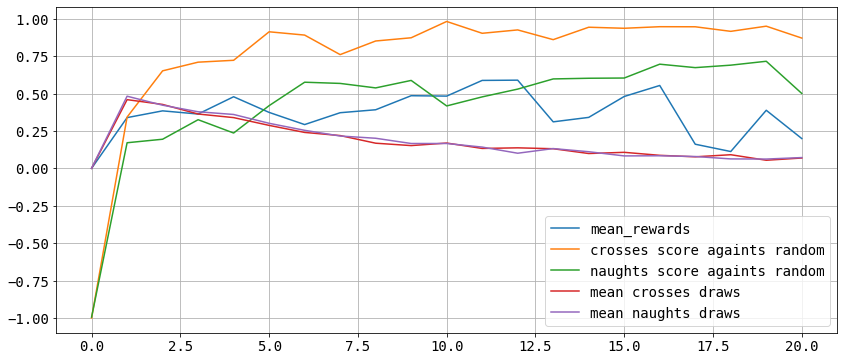

In [40]:
dqn.plot_progress()

#### Double-DQN 3x3x3 

In [41]:
env = TicTacToe(3, 3, 3)
dqn = TicTacToeDQN(env, double_dqn=True)
dqn.fit(20000)

/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/ipykernel_launcher.py:196: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


iter 0: scores crosses -1.0, naughts: -1.0, cur mean rewards: 0, crosses draws: 0.0, naughts draws: 0.001
iter 1000: scores crosses 0.8565, naughts: -0.0755, cur mean rewards: 0.3493975903614458, crosses draws: 0.466, naughts draws: 0.451
iter 2000: scores crosses 0.0735, naughts: -0.003, cur mean rewards: 0.4662576687116564, crosses draws: 0.446, naughts draws: 0.391
iter 3000: scores crosses 0.957, naughts: 0.342, cur mean rewards: 0.4744525547445255, crosses draws: 0.352, naughts draws: 0.374
iter 4000: scores crosses 0.906, naughts: 0.494, cur mean rewards: 0.38375350140056025, crosses draws: 0.346, naughts draws: 0.297
iter 5000: scores crosses 0.922, naughts: 0.435, cur mean rewards: 0.49643705463182897, crosses draws: 0.297, naughts draws: 0.282
iter 6000: scores crosses 0.951, naughts: 0.511, cur mean rewards: 0.5021459227467812, crosses draws: 0.28, naughts draws: 0.254
iter 7000: scores crosses 0.8385, naughts: 0.5795, cur mean rewards: 0.21414538310412573, crosses draws: 0.2

При double dqn я использую отдельную сетку для таргета, которую обновляю периодически новыми весами. Ну тут в принципе не видно, что это дало прям заметный буст в обучении - более менее картина осталась такая же.

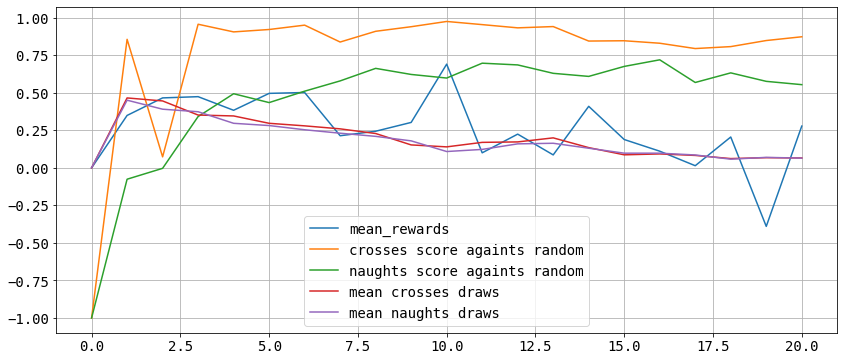

In [42]:
dqn.plot_progress()

#### Double-DQN 3x3x3 w/ Rollouts

Rollouts я использую в двух аспектах - и при оценке, и при обучнении. При обучении я решил дать шанс сначала модели обучиться традиционно: я все еще использую вероятность ответить случайно, но также использую вероятность ответить с использованием rollouts, если первая вероятность экспоненциально уменьшается, то вторая - экспоненциально увеличивается. Мне кажется так можно достичь вариативности в примерах для обучения.

In [192]:
env = TicTacToe(3, 3, 3)
dqn = TicTacToeDQN(env, double_dqn=True, rollouts=True)
dqn.fit(iters=10000)

/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/ipykernel_launcher.py:196: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


iter 0: scores crosses 0.83, naughts: 0.4, cur mean rewards: -1.0, crosses draws: 0.0, naughts draws: 0.0
iter 1000: scores crosses 0.97, naughts: 0.63, cur mean rewards: 0.45132743362831856, crosses draws: 0.47, naughts draws: 0.417
iter 2000: scores crosses 0.96, naughts: 0.69, cur mean rewards: 0.3888888888888889, crosses draws: 0.399, naughts draws: 0.403
iter 3000: scores crosses 0.98, naughts: 0.68, cur mean rewards: 0.40304182509505704, crosses draws: 0.379, naughts draws: 0.358
iter 4000: scores crosses 0.95, naughts: 0.83, cur mean rewards: 0.40963855421686746, crosses draws: 0.327, naughts draws: 0.341
iter 5000: scores crosses 0.98, naughts: 0.79, cur mean rewards: 0.4164588528678304, crosses draws: 0.307, naughts draws: 0.292
iter 6000: scores crosses 0.98, naughts: 0.84, cur mean rewards: 0.45147679324894513, crosses draws: 0.256, naughts draws: 0.27
iter 7000: scores crosses 0.98, naughts: 0.76, cur mean rewards: 0.4397163120567376, crosses draws: 0.224, naughts draws: 0.

Видно, что скоры очень сильно возросли. Даже на первой итерации еще до обучения, скоры уже похожи на те, которые мы видим после обучения простой DQN. Но обучение конечно стало очень медленным.

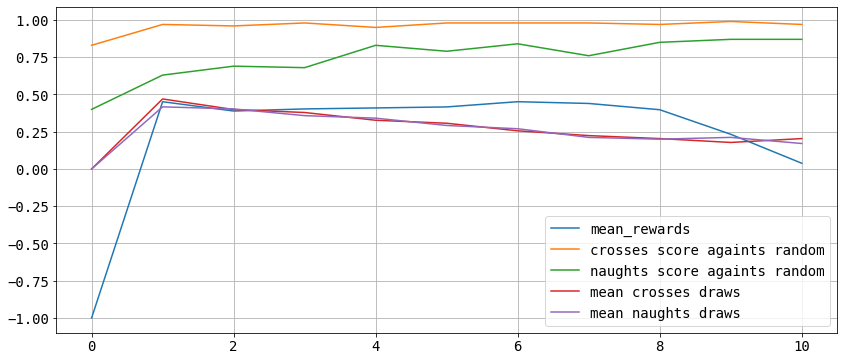

In [193]:
dqn.plot_progress()

#### DQN 4x4x4

In [198]:
env = TicTacToe(4, 4, 4)
dqn = TicTacToeDQN(env, double_dqn=False)
dqn.fit(20000)

/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/ipykernel_launcher.py:196: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


iter 0: scores crosses -1.0, naughts: -0.999, cur mean rewards: 0, crosses draws: 0.001, naughts draws: 0.0
iter 1000: scores crosses 0.0315, naughts: 0.054, cur mean rewards: -1.0, crosses draws: 0.493, naughts draws: 0.504
iter 2000: scores crosses 0.0275, naughts: -0.0245, cur mean rewards: 0.3333333333333333, crosses draws: 0.508, naughts draws: 0.477
iter 3000: scores crosses -0.0915, naughts: -0.031, cur mean rewards: -0.13793103448275862, crosses draws: 0.483, naughts draws: 0.488
iter 4000: scores crosses 0.3665, naughts: 0.148, cur mean rewards: 0.2702702702702703, crosses draws: 0.444, naughts draws: 0.482
iter 5000: scores crosses 0.3525, naughts: 0.317, cur mean rewards: 0.005376344086021506, crosses draws: 0.393, naughts draws: 0.421
iter 6000: scores crosses 0.275, naughts: 0.337, cur mean rewards: 0.08235294117647059, crosses draws: 0.357, naughts draws: 0.388
iter 7000: scores crosses 0.5355, naughts: 0.4825, cur mean rewards: 0.14915254237288136, crosses draws: 0.342, 

Вот для доски 4x4 мы видим как раз таки очень сильное превосходство DQN относительно табличного Q обучения, то есть модель смогла достаточно быстро выработать некоторые рабочие стратегии.

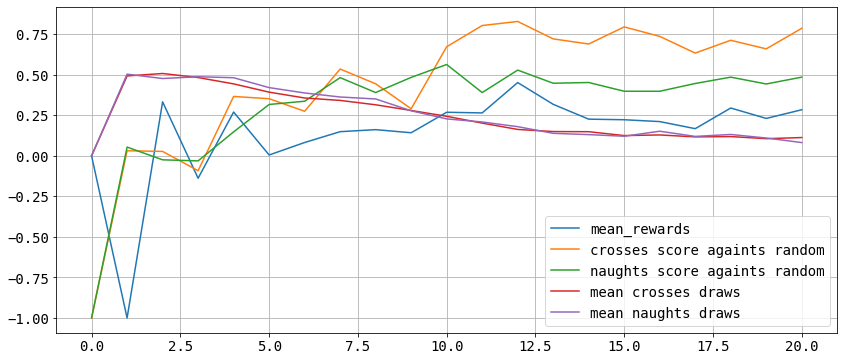

In [199]:
dqn.plot_progress()

#### Double-DQN 4x4x4

In [194]:
env = TicTacToe(4, 4, 4)
dqn = TicTacToeDQN(env, double_dqn=True)
dqn.fit(20000)

/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/ipykernel_launcher.py:196: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


iter 0: scores crosses -1.0, naughts: -1.0, cur mean rewards: 0, crosses draws: 0.001, naughts draws: 0.0
iter 1000: scores crosses 0.1765, naughts: -0.0535, cur mean rewards: 0.5555555555555556, crosses draws: 0.495, naughts draws: 0.496
iter 2000: scores crosses 0.048, naughts: 0.0025, cur mean rewards: 0.25, crosses draws: 0.476, naughts draws: 0.508
iter 3000: scores crosses 0.243, naughts: -0.037, cur mean rewards: 0.28125, crosses draws: 0.491, naughts draws: 0.477
iter 4000: scores crosses 0.1025, naughts: -0.028, cur mean rewards: 0.4, crosses draws: 0.474, naughts draws: 0.471
iter 5000: scores crosses 0.372, naughts: 0.097, cur mean rewards: 0.34545454545454546, crosses draws: 0.459, naughts draws: 0.431
iter 6000: scores crosses 0.3925, naughts: 0.026, cur mean rewards: 0.3802083333333333, crosses draws: 0.406, naughts draws: 0.402
iter 7000: scores crosses 0.6985, naughts: 0.2435, cur mean rewards: 0.40404040404040403, crosses draws: 0.359, naughts draws: 0.344
iter 8000: s

Не скажу, что вижу улучшения относительно обычного DQN, хотя для ноликов вроде стало получше, может я что то не так реализовал или не так настроил, либо эффект просто незаметен и проявит себя на большем кол-ве итераций.

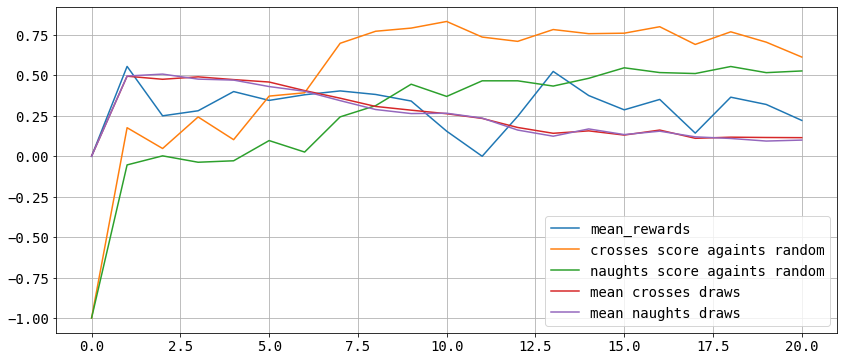

In [195]:
dqn.plot_progress()

#### Double-DQN 4x4x4 w/ Rollouts

In [196]:
env = TicTacToe(4, 4, 4)
dqn = TicTacToeDQN(env, double_dqn=True, rollouts=True)
dqn.fit(iters=10000)

/home/s.yarkin/venv3_upd/lib/python3.6/site-packages/ipykernel_launcher.py:196: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


iter 0: scores crosses 0.54, naughts: 0.27, cur mean rewards: 0, crosses draws: 0.001, naughts draws: 0.0
iter 1000: scores crosses 0.93, naughts: 0.78, cur mean rewards: 0.37142857142857144, crosses draws: 0.464, naughts draws: 0.501
iter 2000: scores crosses 0.92, naughts: 0.71, cur mean rewards: 0.1276595744680851, crosses draws: 0.476, naughts draws: 0.477
iter 3000: scores crosses 0.98, naughts: 0.88, cur mean rewards: 0.25, crosses draws: 0.447, naughts draws: 0.469
iter 4000: scores crosses 0.92, naughts: 0.84, cur mean rewards: 0.31666666666666665, crosses draws: 0.463, naughts draws: 0.417



KeyboardInterrupt: 

rollouts круто себя показывают на доске 4x4, ясно конечно, что сравнение идет относительно случайной стратегии. Но хочется отметить, что случайная стратегия относительно которой везде идет сравнение всегда выбирает доступное действие, то есть не делает совсем глупые ошибки.

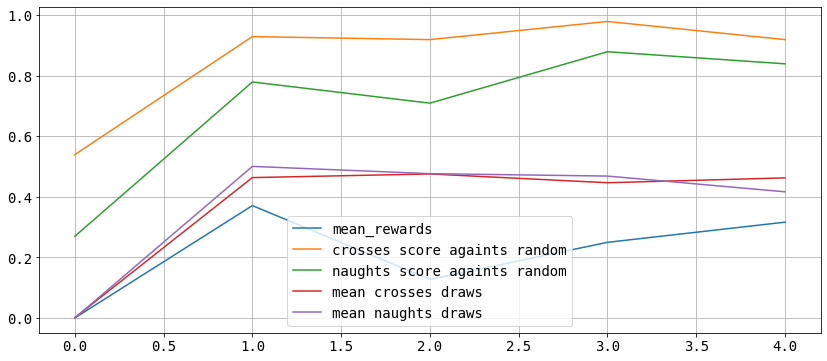

In [197]:
dqn.plot_progress()